# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import gc
import time
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, GRU, LSTM, Bidirectional
from keras.layers import BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from numpy import hstack
from math import sqrt
from scipy.special import boxcox, inv_boxcox

from tensorflow import random

import tensorflow as tf
import pickle
import joblib

2022-11-28 13:17:38.885240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 13:17:38.945689: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-28 13:17:38.961997: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 13:17:39.229866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

# Load CSV

In [2]:
path = 'data.csv'
dataset = pd.read_csv(path, sep=r'\,|\t', engine='python')

# Convert index to datetime

In [3]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset.index = dataset['timestamp'].dt.tz_convert('UTC').dt.tz_convert('Europe/Athens')
dataset = dataset.drop(['timestamp'], inplace=False, axis=1)

# Datetime Engineering

In [4]:
dataset['Month'] = dataset.index.month
dataset['Hour'] = dataset.index.hour
dataset['Minute'] = dataset.index.minute
dataset['DayOfYear'] = dataset.index.strftime('%j').astype(int)
dataset['Date'] = dataset.index.date
dataset['Year'] = dataset.index.year
# Weekday as a number 0-6, 0 is Sunday
dataset['Weekday'] = dataset.index.strftime('%w').astype(int)
# Weekend = 1 else 0
dataset['Weekend'] = dataset.apply (lambda row: 1 if row['Weekday'] in [0,6] else 0, axis=1)

# Remove not in usage type

In [5]:
dataset = dataset.loc[dataset['type'] != 'Not in usage']

In [6]:
dataset

,KWhimport,device,type,Month,Hour,Minute,DayOfYear,Date,Year,Weekday,Weekend
timestamp,,,,,,,,,,,
2017-11-23 15:32:14+02:00,1.1,698,PA1-3,11,15,32,327,2017-11-23,2017,4,0
2017-11-23 15:32:14+02:00,19858.1,694,PA1-1,11,15,32,327,2017-11-23,2017,4,0
2017-11-23 15:32:14+02:00,5245.5,697,PA1-3,11,15,32,327,2017-11-23,2017,4,0
2017-11-23 15:32:14+02:00,3387.9,695,PA1-2,11,15,32,327,2017-11-23,2017,4,0
2017-11-23 15:32:14+02:00,532.8,700,PA1-5,11,15,32,327,2017-11-23,2017,4,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-03 11:27:23+03:00,1.9,700,PA1-5,9,11,27,246,2021-09-03,2021,5,0
2021-09-03 11:27:23+03:00,219025.4,706,PB-1-7,9,11,27,246,2021-09-03,2021,5,0
2021-09-03 11:27:23+03:00,17105.7,705,Abbott Aircondition,9,11,27,246,2021-09-03,2021,5,0


In [7]:
device_hourly_demand = dataset.groupby(['device', 'Date', 'Month', 'DayOfYear', 'Hour'])['KWhimport'].min().reset_index().rename({'KWhimport': 'min_KWhimport'}, axis=1)

In [8]:
device_hourly_demand['max_KWhimport'] = dataset.groupby(['device', 'Date', 'Month', 'DayOfYear', 'Hour'])['KWhimport'].max().reset_index().rename({'KWhimport': 'max_KWhimport'}, axis=1)['max_KWhimport']

In [9]:
device_hourly_demand

,device,Date,Month,DayOfYear,Hour,min_KWhimport,max_KWhimport
0,1,2019-01-01,1,1,0,80329.1,80329.1
1,1,2019-01-31,1,31,23,84587.1,84587.1
2,1,2019-04-01,4,91,1,91066.0,91066.0
3,1,2019-05-01,5,121,0,93556.0,93556.0
4,1,2019-05-01,5,121,1,93556.6,93556.6
...,...,...,...,...,...,...,...
542430,712,2021-09-03,9,246,7,290025.4,290026.6
542431,712,2021-09-03,9,246,8,290032.7,290047.1
542432,712,2021-09-03,9,246,9,290053.2,290059.7
542433,712,2021-09-03,9,246,10,290066.5,290073.3


# KWh consumption during each time interval

In [11]:
device_hourly_demand['diff_KWhimport'] = device_hourly_demand['max_KWhimport'] - device_hourly_demand['min_KWhimport']

In [12]:
device_hourly_demand

,device,Date,Month,DayOfYear,Hour,min_KWhimport,max_KWhimport,diff_KWhimport
0,1,2019-01-01,1,1,0,80329.1,80329.1,0.0
1,1,2019-01-31,1,31,23,84587.1,84587.1,0.0
2,1,2019-04-01,4,91,1,91066.0,91066.0,0.0
3,1,2019-05-01,5,121,0,93556.0,93556.0,0.0
4,1,2019-05-01,5,121,1,93556.6,93556.6,0.0
...,...,...,...,...,...,...,...,...
542430,712,2021-09-03,9,246,7,290025.4,290026.6,1.2
542431,712,2021-09-03,9,246,8,290032.7,290047.1,14.4
542432,712,2021-09-03,9,246,9,290053.2,290059.7,6.5
542433,712,2021-09-03,9,246,10,290066.5,290073.3,6.8


<AxesSubplot: >

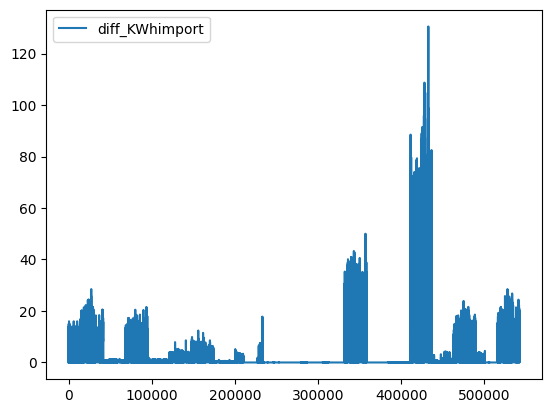

In [13]:
device_hourly_demand.plot(y='diff_KWhimport', use_index=True)

# Drop NaNs

In [14]:
device_hourly_demand = device_hourly_demand.dropna()

# Delete negative diff_KWhimport



In [15]:
device_hourly_demand = device_hourly_demand.loc[device_hourly_demand['diff_KWhimport'] >= 0]

# Drop duplicates

In [16]:
device_hourly_demand = device_hourly_demand.drop_duplicates(keep=False, inplace=False)

In [17]:
dataset['device'].unique()

array([698, 694, 697, 695, 700, 699, 703, 702, 705, 704, 707, 706, 701,
       691, 688, 690, 696, 686, 683, 712,   1])

## Calculate total building demand per hour

In [18]:
total_hourly_demand = pd.DataFrame(device_hourly_demand.groupby(['Date', 'Hour'])['diff_KWhimport'].sum()).reset_index()

In [19]:
total_hourly_demand.sort_values('diff_KWhimport').tail(50)

,Date,Hour,diff_KWhimport
25260,2021-06-30,17,198.7
25256,2021-06-30,13,199.4
12055,2019-08-27,15,199.4
21784,2021-01-20,10,199.7
17737,2020-07-31,11,199.8
22408,2021-02-15,10,200.2
12033,2019-08-26,17,200.3
18626,2020-09-07,14,200.3
25734,2021-07-20,11,200.5
17645,2020-07-27,15,200.8


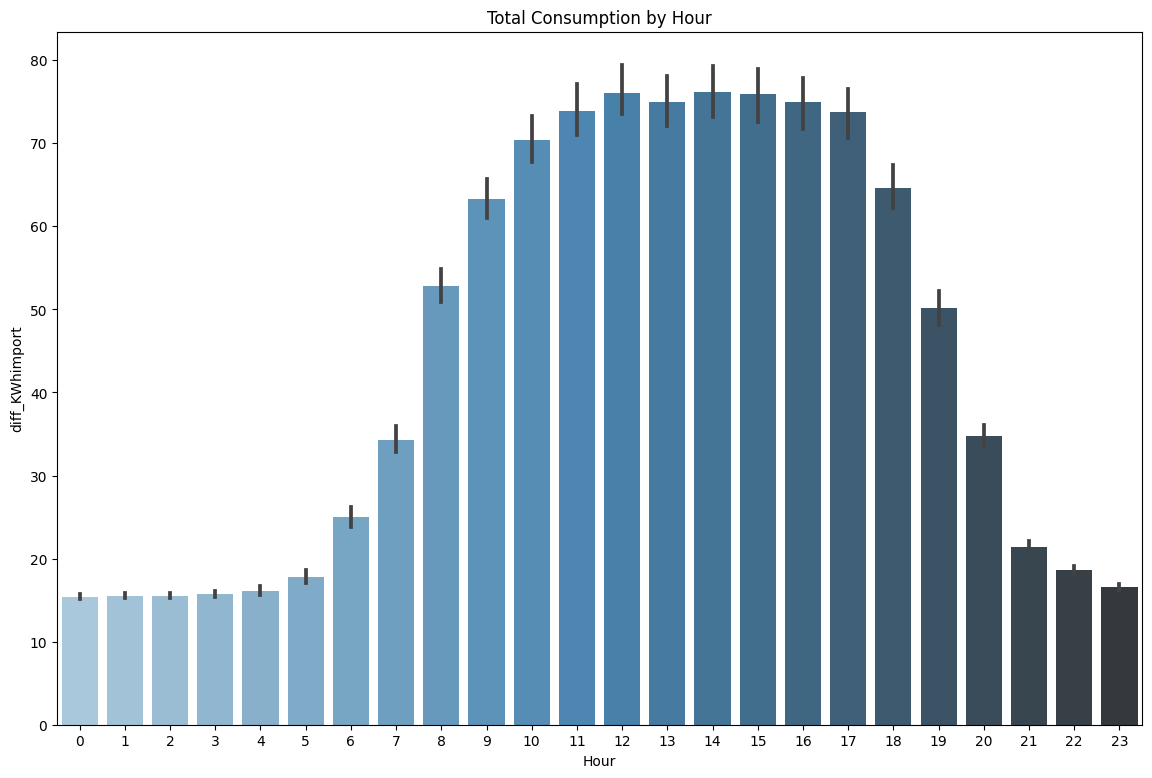

In [20]:
plt.rcParams["figure.figsize"] = [14,9]
ax = plt.axes()
sns.barplot(x="Hour", y='diff_KWhimport', data=total_hourly_demand, palette="Blues_d", ax = ax)
ax.set_title('Total Consumption by Hour')
plt.show()

In [21]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [22]:
def full_model_evaluation(y_true, y_pred):
    
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nrmse = sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true) 
    nd = np.sum(np.abs(y_true-y_pred)) / np.sum(np.abs(y_true))
    
    
    print("Mean Absolute Percentage Error (MAPE) = "+str(mape)+ " %")
    print("R-squared = "+str(r2))
    print("Mean Squared Error (MSE) = "+str(mse))
    print("Root Mean Squared Error (RMSE) = "+str(rmse))
    print("Mean Absolute Error (MAE) = "+str(mae))
    print("Normalized Root Mean Squared Error (NRMSE) = "+str(nrmse))
    print("Normalized deviation (ND) = "+str(nd))
    
    return mape, r2, mse, rmse, mae, nrmse, nd
    

## Prediction of the total hourly buidling demand  with an RNN 

In [23]:
np.random.seed(7)
random.set_seed(7)

In [24]:
y = total_hourly_demand['diff_KWhimport'].values

In [25]:
scalerY = MinMaxScaler()
#scalerY = StandardScaler()
y = y.reshape(-1, 1)
np_scaledY = scalerY.fit_transform(y)
normalizedY = pd.DataFrame(data=np_scaledY, columns=['Energy(kWh)'])

#### RNN encoder input data (past conusmption)

In [26]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [27]:
# horizontally stack column
dataset = hstack((normalizedY.shift(1), normalizedY))
# choose a number of time steps
n_steps = 24*7
# convert into input/output
X_lstm, y_lstm = split_sequences(dataset, n_steps)
print(X_lstm.shape, y_lstm.shape)

(26407, 168, 1) (26407,)


In [28]:
X_lstm[0][0] = X_lstm[0][1]

In [29]:
normalizedY.shift(-n_steps+1).values[0]

array([0.4429982])

In [30]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size = 0.2, shuffle = True)

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [31]:
steps = X_train_lstm.shape[1]
features = X_train_lstm.shape[2]
inputs =  Input(shape=(steps,features,))

gru = GRU(256, kernel_initializer='glorot_uniform', dropout=0, return_sequences=True)(inputs)
gru = GRU(128, kernel_initializer='glorot_uniform', dropout=0, return_sequences=True)(gru)
gru = GRU(64, kernel_initializer='glorot_uniform', dropout=0, return_sequences=False)(gru)
outputs = Dense(1, activation='sigmoid')(gru)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

2022-11-28 13:25:14.085490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 13:25:14.098059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 13:25:14.098145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 13:25:14.098422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 1)]          0         
                                                                 
 gru (GRU)                   (None, 168, 256)          198912    
                                                                 
 gru_1 (GRU)                 (None, 168, 128)          148224    
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 384,449
Trainable params: 384,449
Non-trainable params: 0
_________________________________________________________________


In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, min_delta=0.0001, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'acc'])
history = model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=512, verbose=1, validation_split=0.1, callbacks=[es])

Epoch 1/100


2022-11-28 13:25:41.493114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


 1/38 [..............................] - ETA: 1:22 - loss: 0.1288 - mae: 0.3301 - acc: 0.0000e+00

2022-11-28 13:25:41.710591: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


38/38 [==============================] - 4s 53ms/step - loss: 0.0486 - mae: 0.1740 - acc: 0.0059 - val_loss: 0.0229 - val_mae: 0.1135 - val_acc: 0.0057
Epoch 2/100
38/38 [==============================] - 2s 49ms/step - loss: 0.0144 - mae: 0.0867 - acc: 0.0057 - val_loss: 0.0113 - val_mae: 0.0746 - val_acc: 0.0052
Epoch 3/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0118 - mae: 0.0752 - acc: 0.0056 - val_loss: 0.0109 - val_mae: 0.0730 - val_acc: 0.0052
Epoch 4/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0110 - mae: 0.0725 - acc: 0.0056 - val_loss: 0.0107 - val_mae: 0.0711 - val_acc: 0.0052
Epoch 5/100
38/38 [==============================] - 2s 48ms/step - loss: 0.0101 - mae: 0.0682 - acc: 0.0056 - val_loss: 0.0101 - val_mae: 0.0686 - val_acc: 0.0052
Epoch 6/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0099 - mae: 0.0671 - acc: 0.0056 - val_loss: 0.0102 - val_mae: 0.0709 - val_acc: 0.0052
Epoch 7/100
38/38 [=========

Epoch 51/100
38/38 [==============================] - 2s 46ms/step - loss: 0.0052 - mae: 0.0441 - acc: 0.0057 - val_loss: 0.0055 - val_mae: 0.0461 - val_acc: 0.0052
Epoch 52/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0052 - mae: 0.0441 - acc: 0.0057 - val_loss: 0.0055 - val_mae: 0.0464 - val_acc: 0.0052
Epoch 53/100
38/38 [==============================] - 2s 43ms/step - loss: 0.0051 - mae: 0.0435 - acc: 0.0057 - val_loss: 0.0055 - val_mae: 0.0444 - val_acc: 0.0052
Epoch 54/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0049 - mae: 0.0424 - acc: 0.0056 - val_loss: 0.0052 - val_mae: 0.0423 - val_acc: 0.0052
Epoch 55/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0048 - mae: 0.0417 - acc: 0.0057 - val_loss: 0.0053 - val_mae: 0.0453 - val_acc: 0.0052
Epoch 56/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0048 - mae: 0.0418 - acc: 0.0057 - val_loss: 0.0052 - val_mae: 0.0418 - val_acc: 0.0052
Epoch 57/1

38/38 [==============================] - 2s 48ms/step - loss: 0.0030 - mae: 0.0320 - acc: 0.0059 - val_loss: 0.0046 - val_mae: 0.0369 - val_acc: 0.0052


166/166 [==============================] - 3s 16ms/step - loss: 0.0042 - mae: 0.0360 - acc: 0.0062
MSE=0.004185035824775696
MAE=0.0359850749373436
ACC=0.0062476336024701595


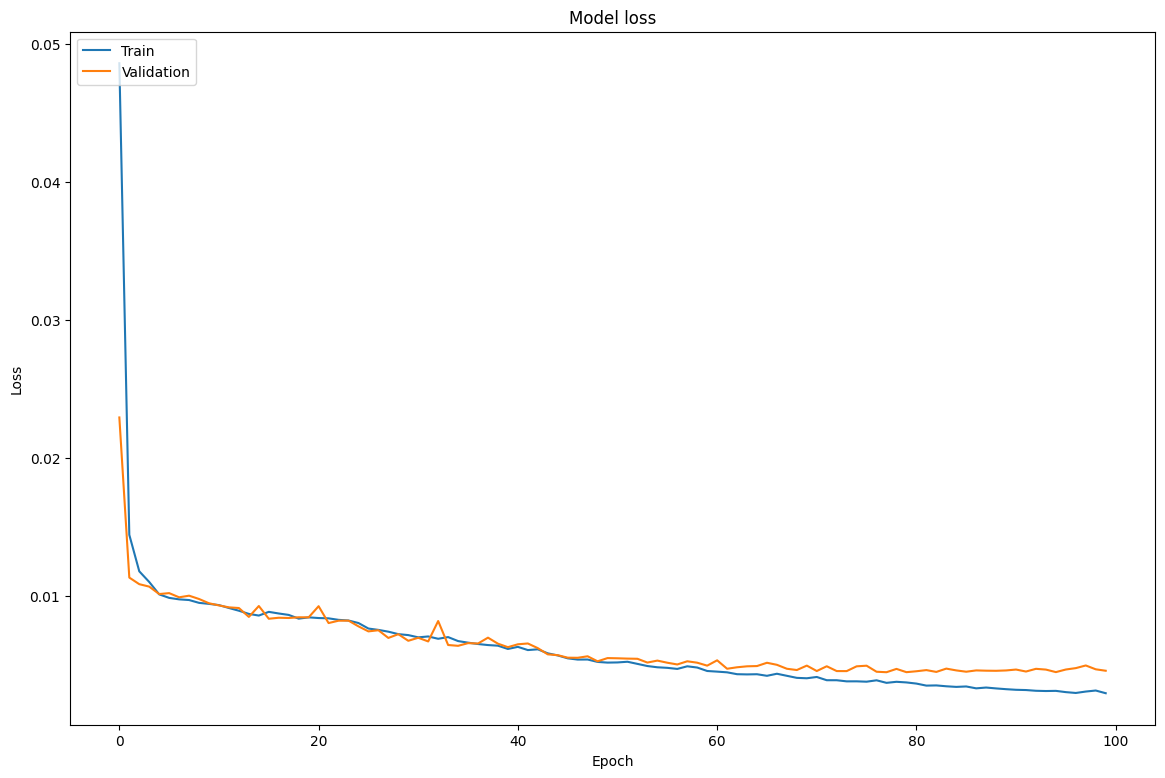

In [33]:
y_pred = model.predict(X_test_lstm)

evaluation = model.evaluate(x = X_test_lstm, y = y_test_lstm, verbose=1) # Returns MSE, MAE, ACC
mse = evaluation[0]
mae = evaluation[1]
acc = evaluation[2]
print('MSE='+str(mse))
print('MAE='+str(mae))
print('ACC='+str(acc))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

72/72 [==============================] - 1s 13ms/step


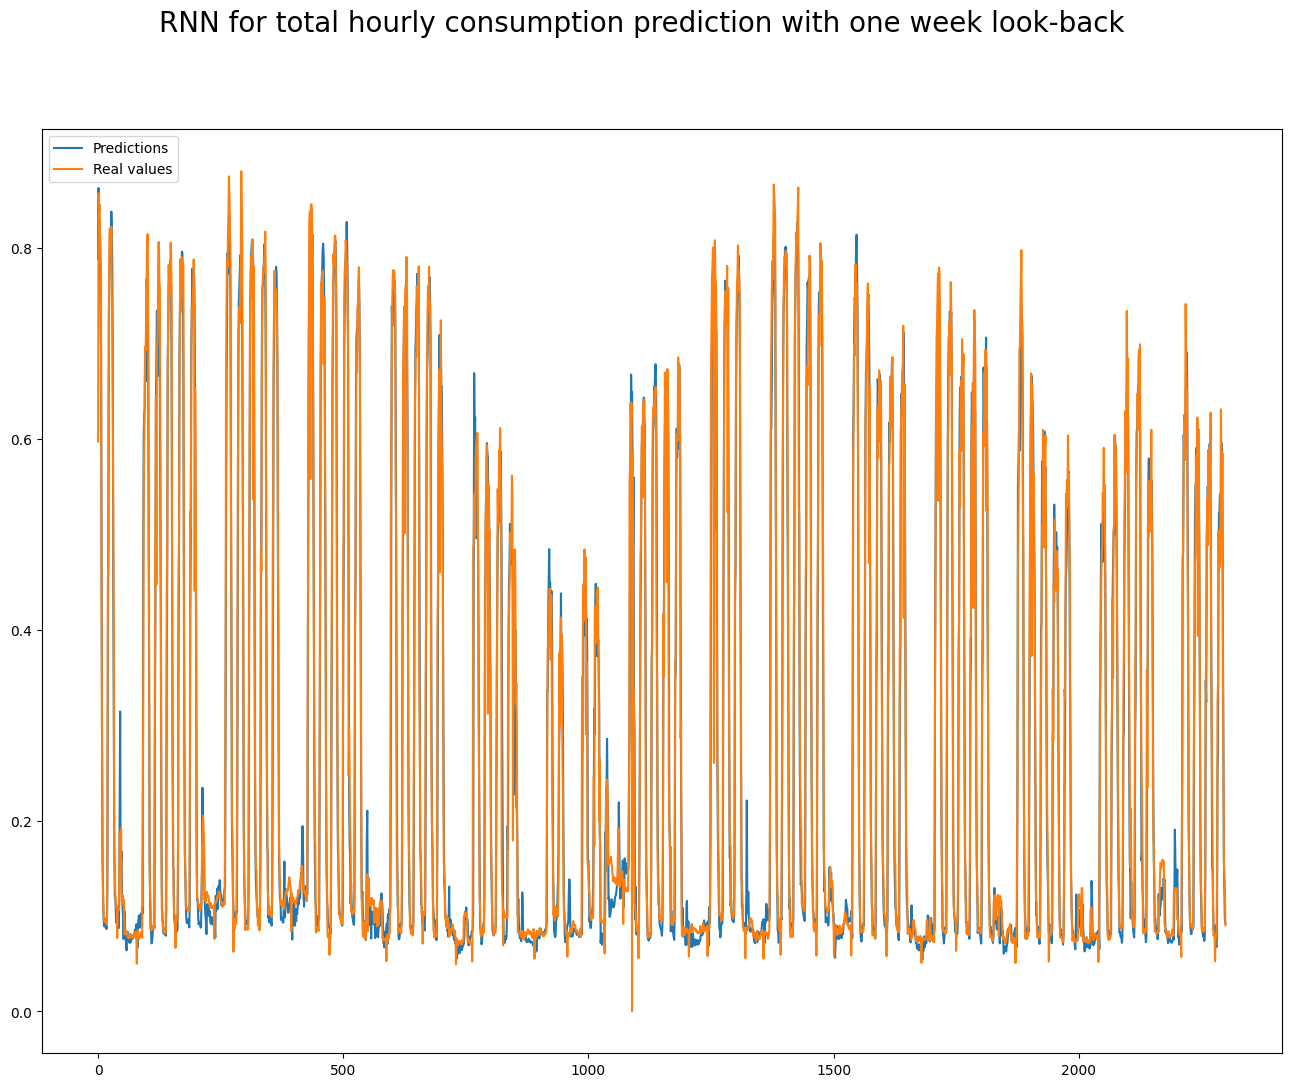

In [34]:
%matplotlib inline
prediction = model.predict(X_lstm[3900:6200])
real = y_lstm[3900:6200]
plt.rcParams["figure.figsize"] = [16,12]

plt.suptitle('RNN for total hourly consumption prediction with one week look-back', fontsize=20)
plt.plot(prediction, label='Predictions')
plt.plot(real, label='Real values')
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"] = [12,9]
plt.show()

### Evaluation after inverse tranformations

In [35]:
y_test_lstm = scalerY.inverse_transform(y_test_lstm.reshape(-1,1))

In [36]:
y_pred = model.predict(X_test_lstm)

166/166 [==============================] - 2s 13ms/step


In [37]:
y_pred = scalerY.inverse_transform(y_pred)

In [38]:
np.mean(y_test_lstm) 

44.13227943960698

In [39]:
full_model_evaluation(y_test_lstm, y_pred)

Mean Absolute Percentage Error (MAPE) = 21.404597873826788 %
R-squared = 0.8845139137194442
Mean Squared Error (MSE) = 207.74449420996433
Root Mean Squared Error (RMSE) = 14.413344310393905
Mean Absolute Error (MAE) = 8.017476978359177
Normalized Root Mean Squared Error (NRMSE) = 0.32659415043625634
Normalized deviation (ND) = 0.18166922443538702


(21.404597873826788,
 0.8845139137194442,
 207.74449420996433,
 14.413344310393905,
 8.017476978359177,
 0.32659415043625634,
 0.18166922443538702)

41/41 [==============================] - 1s 14ms/step


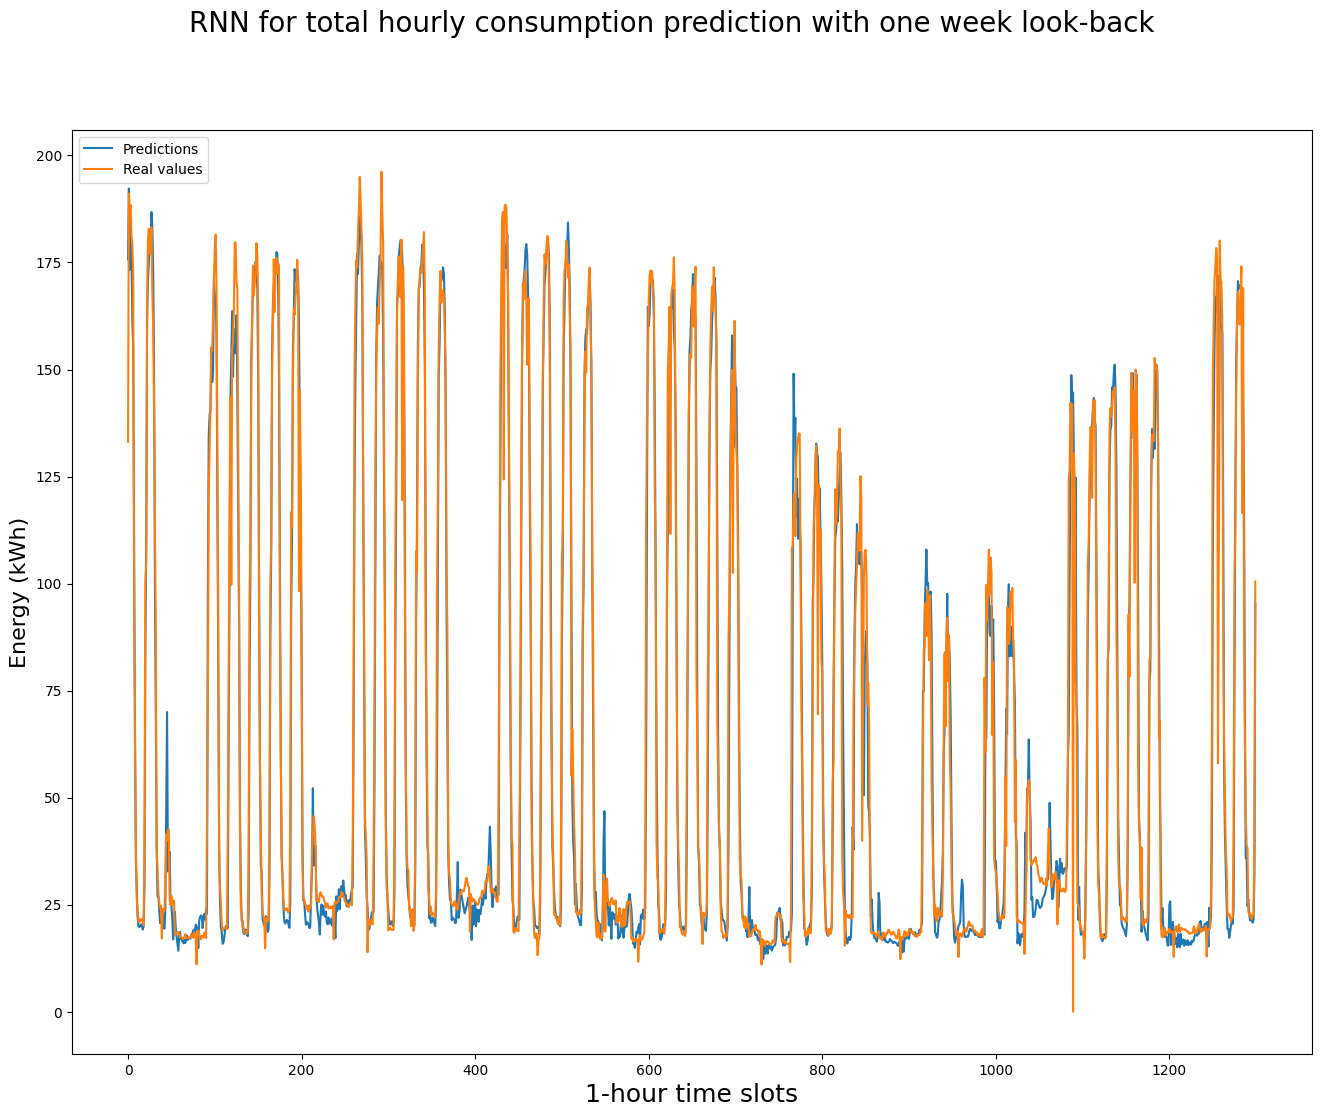

In [40]:
%matplotlib inline
prediction = scalerY.inverse_transform(model.predict(X_lstm[3900:5200]))
real = scalerY.inverse_transform(y_lstm[3900:5200].reshape(-1,1))
plt.rcParams["figure.figsize"] = [16,12]

plt.suptitle('RNN for total hourly consumption prediction with one week look-back', fontsize=20)
plt.plot(prediction, label='Predictions')
plt.plot(real, label='Real values')
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"] = [12,9]
plt.xlabel('1-hour time slots', fontsize=18)
plt.ylabel('Energy (kWh)', fontsize=16)
plt.show()

In [41]:
model.save('building_GRU.h5')